In [1]:
from __future__ import division

import os

import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.mlab as mlab
import pandas as pd
import datetime
import pytz
import math

import seaborn as sns
%matplotlib inline

from datetime import date, timedelta, datetime
from scipy import stats

In [2]:
local_tz = pytz.timezone('America/Los_Angeles')

holidays = pd.read_csv('holiday.csv', usecols=[0])
holidays['date'] = pd.to_datetime(pd.Series(holidays['date']), format='%m/%d/%y')
holidays['day'] = holidays.date.apply(lambda x: x.strftime('%Y-%m-%d'))

In [36]:
def remove_dst(x):
    if x.dst()/pd.Timedelta(hours=1) == 0:
        pass
    else:
        x = x.replace(tzinfo=None) - timedelta(hours=1)
    return x.strftime('%Y-%m-%d %H:%M:%S')

In [37]:
df['timestamp_pst'] = [remove_dst(x) for x in df.index]
df.to_csv('meter-data/B275-21demand-Clean.csv')

In [51]:
def clean_meter_data(inputfile):
    df = pd.read_csv(inputfile, index_col=[0], parse_dates=True, skiprows=3, usecols=[0,3])
    df['timestamp_pst'] = [remove_dst(x) for x in df.index]
    df.index = pd.to_datetime(df['timestamp_pst'], format='%Y-%m-%d %H:%M:%S')
    del df['timestamp_pst']
    df.columns = ['power']
    df['power'] = [float(x.split()[0]) for x in df.power]
    # add datetime indicator
    df['day'] = list(map(lambda x: x.strftime('%m/%d/%y'),df.index))
    df['time'] = list(map(lambda x: x.strftime('%H:%M'),df.index))
    df['month'] = list(map(lambda x: x.strftime('%m'),df.index))
    df['hour'] = list(map(lambda x: x.strftime('%H'),df.index))
    df['month'] = df.month.astype(int)
    df['hour'] = df.hour.astype(int)
    df['weekday'] = df.index.weekday
    df['year'] = df.index.year
    df['holiday'] = list(map(lambda x: x.strftime('%Y-%m-%d') in holidays.day.values,df.index))
    df['holiday'] = df.holiday.astype(int)
    
    return df

In [52]:
b275 = clean_meter_data('meter-data/B275-21demand.csv')
b275.to_csv('meter-data/B275-21demand-Clean.csv')

In [54]:
b282 = clean_meter_data('meter-data/B282-21demand.csv')
b282.to_csv('meter-data/B282-21demand-Clean.csv')

<AxesSubplot:xlabel='timestamp_pst'>

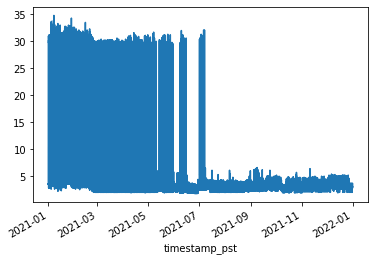

In [53]:
b275.power.plot()

<AxesSubplot:xlabel='timestamp_pst'>

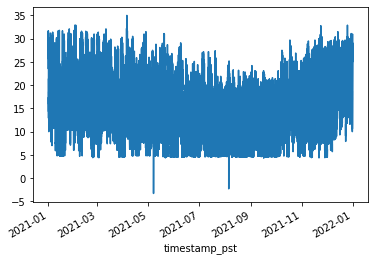

In [55]:
b282.power.plot()

In [60]:
b282_month = b282.loc[b282['weekday']>0].groupby(['month','hour'])['power'].mean()
b282_month = b282_month.reset_index()

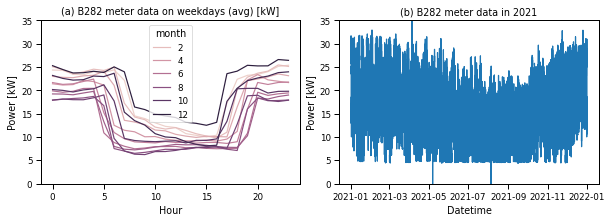

In [69]:
sns.set_context('paper')
fig, (axes) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .1, wspace=.15)
# fig.suptitle("Northern and Southern PV Carport System", fontsize=12)
# for item in b282_month.index.levels[0]:
#     b282_month.loc[item,:].plot(ax=axes[0],label=item,legend=True)
sns.lineplot(x='hour', y='power', hue='month', data=b282_month, ax=axes[0])
axes[1].plot(b282.power)
axes[0].set_title("(a) B282 meter data on weekdays (avg) [kW]")
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Power [kW]')
axes[0].set_ylim(0,35)
# axes[0].legend(b282_month.index.levels[0])
axes[1].set_title("(b) B282 meter data in 2021")
axes[1].set_ylabel('Power [kW]')
axes[1].set_xlabel('Datetime')
axes[1].set_ylim(0,35)
fig.savefig('results/b282-meter-data.png', dpi=300, format='png',bbox_inches='tight')

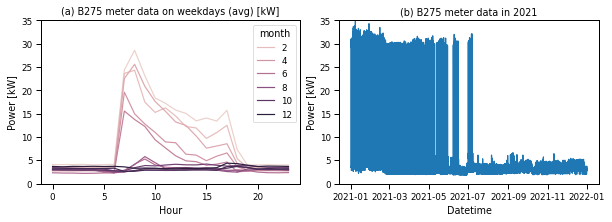

In [71]:
b275_month = b275.loc[b275['weekday']>0].groupby(['month','hour'])['power'].mean()
b275_month = b275_month.reset_index()

fig, (axes) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .1, wspace=.15)
sns.lineplot(x='hour', y='power', hue='month', data=b275_month, ax=axes[0])
axes[1].plot(b275.power)
axes[0].set_title("(a) B275 meter data on weekdays (avg) [kW]")
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Power [kW]')
axes[0].set_ylim(0,35)
# axes[0].legend(b282_month.index.levels[0])
axes[1].set_title("(b) B275 meter data in 2021")
axes[1].set_ylabel('Power [kW]')
axes[1].set_xlabel('Datetime')
axes[1].set_ylim(0,35)
fig.savefig('results/b275-meter-data.png', dpi=300, format='png',bbox_inches='tight')

In [88]:
weather = pd.read_csv('meter-data/Camp-Parks_2021-01-01_2022-01-01_Weather.csv')
weather = weather.set_index('datetime')
weather['oat'] = weather['temperature']*1.8+32
weather.index = pd.to_datetime(weather.index, format='%Y-%m-%d %H:%M:%S')

In [89]:
weather.head()

,time,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,ozone,oat
datetime,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,2021-01-01 00:00:00-08:00,Clear,clear-night,0.0,0.0,8.35,8.35,3.18,0.70,1020.8,1.30,2.46,14.0,0.00,0.0,16.016,NaN,NaN,47.030
2021-01-01 01:00:00,2021-01-01 01:00:00-08:00,Clear,clear-night,0.0,0.0,8.35,7.57,2.70,0.68,1020.6,1.68,2.83,70.0,0.01,0.0,16.065,NaN,NaN,47.030
2021-01-01 02:00:00,2021-01-01 02:00:00-08:00,Clear,clear-night,0.0,0.0,8.03,7.39,2.32,0.67,1020.9,1.51,2.56,28.0,0.01,0.0,13.925,NaN,NaN,46.454
2021-01-01 03:00:00,2021-01-01 03:00:00-08:00,Clear,clear-night,0.0,0.0,8.02,6.92,1.98,0.66,1020.5,1.97,3.37,50.0,0.01,0.0,13.202,NaN,NaN,46.436
2021-01-01 04:00:00,2021-01-01 04:00:00-08:00,Clear,clear-night,0.0,0.0,7.47,6.03,1.52,0.66,1020.2,2.25,3.54,60.0,0.02,0.0,16.093,NaN,NaN,45.446


In [95]:
weather = weather[~weather.index.duplicated(keep='first')]
df = pd.concat([b282, weather['oat']], axis=1)
df['oat'] = df['oat'].fillna(method='backfill')
df.head()

,power,day,time,month,hour,weekday,year,holiday,oat
2021-01-01 00:00:00,30.4,01/01/21,00:00,1.0,0.0,4.0,2021.0,1.0,47.03
2021-01-01 00:15:00,29.0,01/01/21,00:15,1.0,0.0,4.0,2021.0,1.0,47.03
2021-01-01 00:30:00,28.9,01/01/21,00:30,1.0,0.0,4.0,2021.0,1.0,47.03
2021-01-01 00:45:00,29.0,01/01/21,00:45,1.0,0.0,4.0,2021.0,1.0,47.03
2021-01-01 01:00:00,28.7,01/01/21,01:00,1.0,1.0,4.0,2021.0,1.0,47.03


In [ ]:
# calculate basepower on weekdays
df.loc[:,'basepower'] = 0
df.loc[:,'peakoat'] = 0

# calculate the daily peak OAT
PeakOAT = df.groupby(['day'])['oat'].max()

for day in PeakOAT.index:
    df.loc[(df['day'] == day),'peakoat'] = PeakOAT[day]

# subset the weekday and weekend power
df_wd = df.loc[(df['weekday'] >= 0) & (df['weekday'] <= 4) & (df['holiday'] == 0)]
df_wk = df.loc[(df.weekday.apply(lambda x: x in [5,6])) | (df['holiday'] == 1)]

# calculate the basepower on weekdays and weekend
df_wd_base = df_wd.loc[(df_wd['oat'] < 68)]
df_wd_basedaily = df_wd_base.pivot(index='time',columns='day',values='BldgPowerOnly')
df_wk_base = df_wk.loc[(df_wk['oat'] < 68)]
df_wk_basedaily = df_wk_base.pivot(index='time',columns='day',values='BldgPowerOnly')

for tim in df_wd_basedaily.index:
    try:
        df.loc[(df['time'] == tim) & (df['weekday'] >= 0) & \
           (df['weekday'] <= 4) & (df['holiday'] == 0),'basepower'] = df_wd_basedaily.mean(axis=1)[tim]
        df.loc[(df['time'] == tim) & (df.weekday.apply(lambda x: x in [5,6])),'basepower'] = df_wk_basedaily.mean(axis=1)[tim]
        df.loc[(df['time'] == tim) & (df['holiday'] == 1),'basepower'] = df_wk_basedaily.mean(axis=1)[tim]
    except KeyError:
        pass
df.loc[:,'hvac'] = df.BldgPowerOnly - df.basepower

In [ ]:
# Resample data into hourly demand
def Load_Duration(data, BuildingID):
    HourlyLoad = data['2016'].resample('H').mean()
    HourlyLoad_order = HourlyLoad.sort_values(by=['BldgPowerOnly'],ascending=False)['BldgPowerOnly']

    sns.set_context('paper')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharex=False)

    ax2.plot(range(len(HourlyLoad)),HourlyLoad_order,label='Hourly Demand')
    ax2.set_xlabel('Hour of Year 2016')
    ax2.set_ylabel('Power, kW')
    ax2.set_title(BuildingID + ':Building Load Duration Curve in 2016')
    ax2.legend()
    
    df_wd = data.loc[(data['weekday'] >= 0) & (data['weekday'] <= 4)]
    df_wd_daily = df_wd.pivot(index='time',columns='day',values='BldgPowerOnly')
    
    df_wd_daily.plot(ax=ax1,c='gray',alpha=0.8)
    ax1.plot(df_wd_daily.mean(axis=1).values,c='b',label='Average Power')
    ax1.set_ylabel('Power, [kW]')
    ax1.set_xlabel('Hour of Day')
    ax1.set_title(BuildingID + ':Daily Power on Weekdays in 2016')
    ax1.legend().set_visible(False)
    
    path = '../results/' + BuildingID
    if not os.path.exists(path):
        os.makedirs(path)

    fig.savefig(path + '/' + BuildingID + '_LoadCurve.png',dpi=300, format='png',bbox_inches='tight')

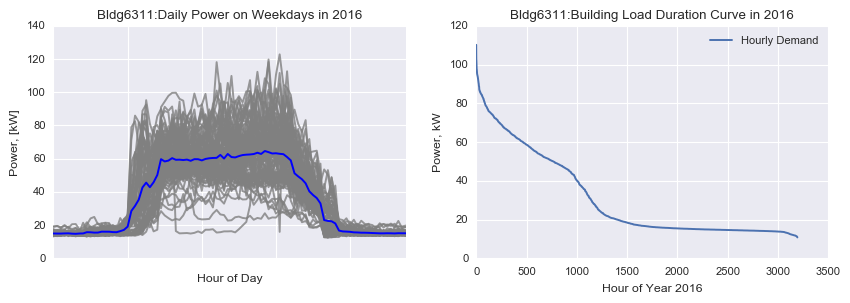

In [ ]:
BuildingID = 'Bldg6311'
data = df.copy()
HourlyLoad = df['2016'].resample('H').mean()
HourlyLoad_order = HourlyLoad.sort_values(by=['BldgPowerOnly'],ascending=False)['BldgPowerOnly']

sns.set_context('paper')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharex=False)

ax2.plot(range(len(HourlyLoad)),HourlyLoad_order,label='Hourly Demand')
ax2.set_xlabel('Hour of Year 2016')
ax2.set_ylabel('Power, kW')
ax2.set_title(BuildingID + ':Building Load Duration Curve in 2016')
ax2.legend()

df_wd = data.loc[(data['weekday'] >= 0) & (data['weekday'] <= 4)]
df_wd_daily = df_wd.pivot(index='time',columns='day',values='BldgPowerOnly')

df_wd_daily.plot(ax=ax1,c='gray',alpha=0.8)
ax1.plot(df_wd_daily.mean(axis=1).values,c='b',label='Average Power')
ax1.set_ylabel('Power, [kW]')
ax1.set_xlabel('Hour of Day')
ax1.set_title(BuildingID + ':Daily Power on Weekdays in 2016')
ax1.legend().set_visible(False)

path = '../results/' + BuildingID
if not os.path.exists(path):
    os.makedirs(path)

fig.savefig(path + '/' + BuildingID + '_LoadCurve.png',dpi=300, format='png',bbox_inches='tight')

In [ ]:
df.head()

,Bldg,date,day,time,month,hour,weekday,year,holiday,RooftopSolar,BldgPowerOnly,Month/Year,oat
date,,,,,,,,,,,,,
2016-08-21 00:00:00,16.4,2016-08-21 00:00:00,08/21/16,00:00,8,0,6,2016,0,0.0,16.4,2016/08,67.568
2016-08-21 00:15:00,16.4,2016-08-21 00:15:00,08/21/16,00:15,8,0,6,2016,0,0.0,16.4,2016/08,67.460
2016-08-21 00:30:00,15.6,2016-08-21 00:30:00,08/21/16,00:30,8,0,6,2016,0,0.0,15.6,2016/08,67.352
2016-08-21 00:45:00,16.5,2016-08-21 00:45:00,08/21/16,00:45,8,0,6,2016,0,0.0,16.5,2016/08,67.244
2016-08-21 01:00:00,15.4,2016-08-21 01:00:00,08/21/16,01:00,8,1,6,2016,0,0.0,15.4,2016/08,67.136


In [ ]:
# Resample data into hourly demand
def hourly_boxplot(data, BuildingID):
    
    df = data['2016']
    df_wd = df.loc[(df['weekday'] >= 0) & (df['weekday'] <= 4)]
    df_wk = df.loc[df.weekday.apply(lambda x: x in [5,6])]
    df_wd_hourly = df_wd.pivot(index='date',columns='hour',values='BldgPowerOnly')
    df_wk_hourly = df_wk.pivot(index='date',columns='hour',values='BldgPowerOnly')
    
    sns.set_context('paper')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharey=True)
    fig.subplots_adjust(hspace = .1, wspace = .1)

    df_wd_hourly.boxplot(ax=ax1)
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Power, kW')
    ax1.set_title(BuildingID + ':Hourly Distribution on Weekdays in 2016')
    
    df_wk_hourly.boxplot(ax=ax2)
    ax2.set_ylabel('Power, [kW]')
    ax2.set_xlabel('Hour of Day')
    ax2.set_title(BuildingID + ':Hourly Distribution on Weekends in 2016')
    
    path = '../results/' + BuildingID
    if not os.path.exists(path):
        os.makedirs(path)

    fig.savefig(path + '/' + BuildingID + '_BoxPlot.png',dpi=300, format='png',bbox_inches='tight')

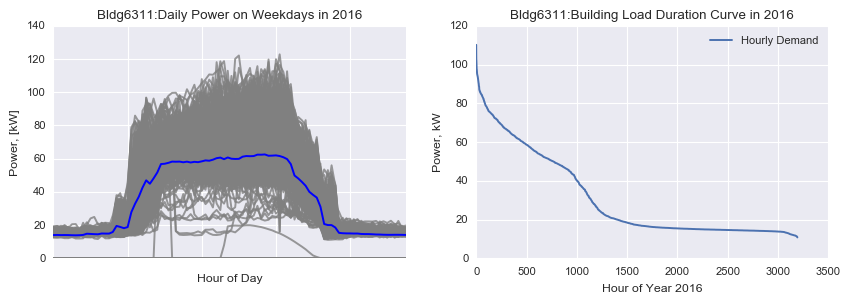

In [ ]:
Load_Duration(df, 'Bldg6311')

/Users/ryin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
/Users/ryin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


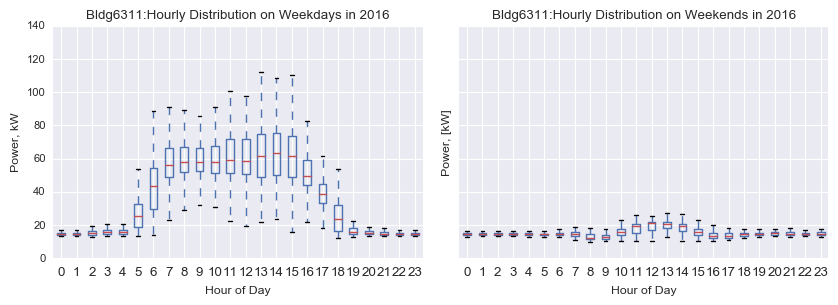

In [ ]:
hourly_boxplot(df, 'Bldg6311')

In [ ]:
def hvac_scatter_1(df, BuildingID):
    df = df['2016']
    
    df_wd = df.loc[(df['weekday'] >= 0) & (df['weekday'] <= 4) & (df['holiday'] == 0)]
    df_wk = df.loc[(df.weekday.apply(lambda x: x in [5,6])) | (df['holiday'] == 1)]
    
    df_wd_hvac = df_wd.loc[(df_wd['peakoat'] >= 68)]

    fig, axes = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k', sharey=True, sharex=True)
    fig.subplots_adjust(hspace = .2, wspace = .1)
    
    for i in range(6,12,1):
        x0 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] <= 55),['oat','hvac']].oat
        y0 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] <= 55),['oat','hvac']].hvac
        x1 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] <= 68) & (df_wd_hvac['oat'] > 55),['oat','hvac']].oat
        y1 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] <= 68) & (df_wd_hvac['oat'] > 55),['oat','hvac']].hvac
        x2 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] > 68),['oat','hvac']].oat
        y2 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] > 68),['oat','hvac']].hvac
        
        TempBreaks = [55,68,95]
        try:
            z0 = np.polyfit(x0,y0,1)
            p0 = np.poly1d(z0)
            xp0 = np.linspace(min(x0),TempBreaks[0],100)
            slope0, intercept0, r_value0, p_value0, std_err0 = stats.linregress(x0,y0)
            z0_err = [r_value0**2, std_err0]
            r_err0 = abs(((x0 * slope0 + intercept0)-y0) / y0)
            
            z1 = np.polyfit(x1,y1,1)
            p1 = np.poly1d(z1)
            xp1 = np.linspace(min(x1),TempBreaks[1],100)
            slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)
            z1_err = [r_value1**2, std_err1]
            r_err1 = abs(((x1 * slope1 + intercept1)-y1) / y1)
            
            z2 = np.polyfit(x2, y2, 1)
            p2 = np.poly1d(z2)
            xp2 = np.linspace(TempBreaks[1], max(x2), 100)
            slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2,y2)
            z2_err = [r_value2**2, std_err2]
            r_err2 = abs(((x2 * slope2 + intercept2)-y2) / y2)


        except TypeError:
            print("Empty OAT >= 68F")
        axes.ravel()[i-6].plot(x0,y0,'o',label='OAT <= 55F',ms=4)
        axes.ravel()[i-6].plot(x1,y1,'o',label='OAT <= 68F',ms=4)
        axes.ravel()[i-6].plot(x2, y2, 'o', label = 'OAT > 68F',ms=4)
        axes.ravel()[i-6].plot(xp0,p0(xp0),'-')
        axes.ravel()[i-6].plot(xp1,p1(xp1),'-')
        axes.ravel()[i-6].plot(xp2, p2(xp2), '-')
        axes.ravel()[i-6].set_title(str(i)+':00'+'~'+str(i+1)+':00',color='red')
        if i >= 9:
            axes.ravel()[i-6].set_xlabel('Outside Air Temperature, [$^\circ$F]')
        axes.ravel()[i-6].set_ylabel('HVAC Power, [kW]')

    path = '../results/' + BuildingID
    if not os.path.exists(path):
        os.makedirs(path)

    fig.savefig(path + '/' + BuildingID + '_Linear_1.png',dpi=300, format='png',bbox_inches='tight')
    

def hvac_scatter_2(df, BuildingID):
    df = df['2016']
    
    df_wd = df.loc[(df['weekday'] >= 0) & (df['weekday'] <= 4) & (df['holiday'] == 0)]
    df_wk = df.loc[(df.weekday.apply(lambda x: x in [5,6])) | (df['holiday'] == 1)]
    
    df_wd_hvac = df_wd.loc[(df_wd['peakoat'] >= 68)]

    fig, axes = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k', sharey=True, sharex=True)
    fig.subplots_adjust(hspace = .2, wspace = .1)
    
    for i in range(12,18,1):
        x1 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] <= 68),['oat','hvac']].oat
        y1 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] <= 68),['oat','hvac']].hvac
        x2 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] > 68),['oat','hvac']].oat
        y2 = df_wd_hvac.loc[(df_wd_hvac['hour'] == i) & (df_wd_hvac['oat'] > 68),['oat','hvac']].hvac
        
        TempBreaks = [68,95]
        try:
            z1 = np.polyfit(x1,y1,1)
            p1 = np.poly1d(z1)
            xp1 = np.linspace(min(x1),TempBreaks[0],100)
            slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)
            z1_err = [r_value1**2, std_err1]
            r_err1 = abs(((x1 * slope1 + intercept1)-y1) / y1)
            
            z2 = np.polyfit(x2, y2, 1)
            p2 = np.poly1d(z2)
            xp2 = np.linspace(TempBreaks[0], max(x2), 100)
            slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2,y2)
            z2_err = [r_value2**2, std_err2]
            r_err2 = abs(((x2 * slope2 + intercept2)-y2) / y2)

            axes.ravel()[i-12].plot(x1,y1,'o',label='OAT <= 68F',color='green',alpha=0.7,ms=4)
            axes.ravel()[i-12].plot(x2, y2, 'o', label = 'OAT > 68F',color='darkred',alpha=0.6,ms=4)
            axes.ravel()[i-12].plot(xp1,p1(xp1),'-')
            axes.ravel()[i-12].plot(xp2, p2(xp2), '-')
            axes.ravel()[i-12].set_title(str(i)+':00'+'~'+str(i+1)+':00',color='red')
        except TypeError:
            print("Empty OAT >= 68F")
        
        if i >= 15:
            axes.ravel()[i-12].set_xlabel('Outside Air Temperature, [$^\circ$F]')
        axes.ravel()[i-12].set_ylabel('HVAC Power, [kW]')

    path = '../results/' + BuildingID
    if not os.path.exists(path):
        os.makedirs(path)

    fig.savefig(path + '/' + BuildingID + '_Linear_2.png',dpi=300, format='png',bbox_inches='tight')
    

Empty OAT >= 68F
Empty OAT >= 68F


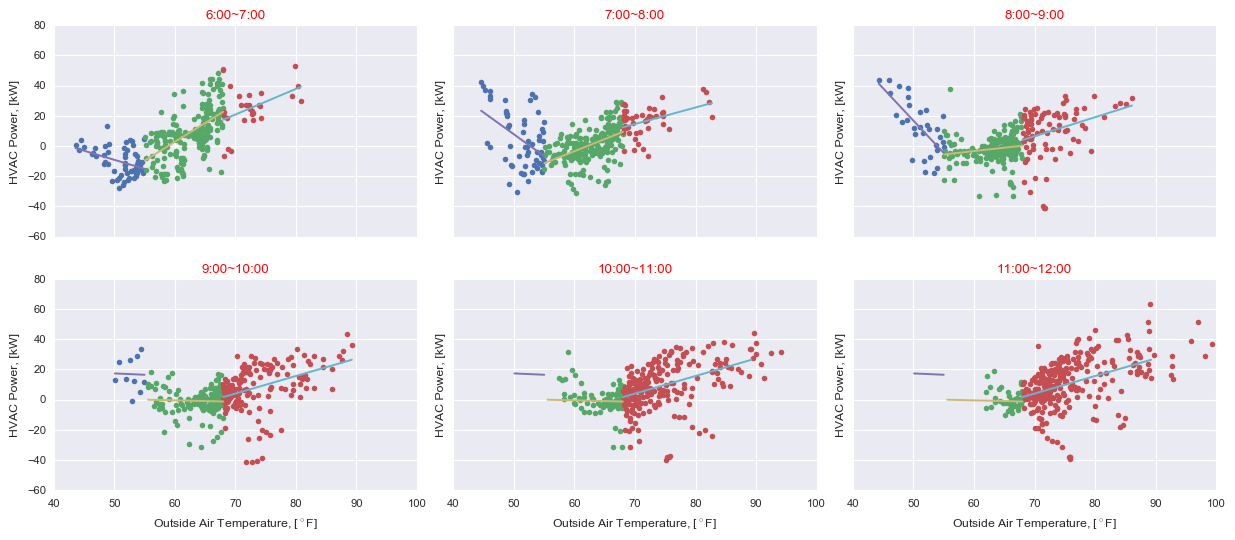

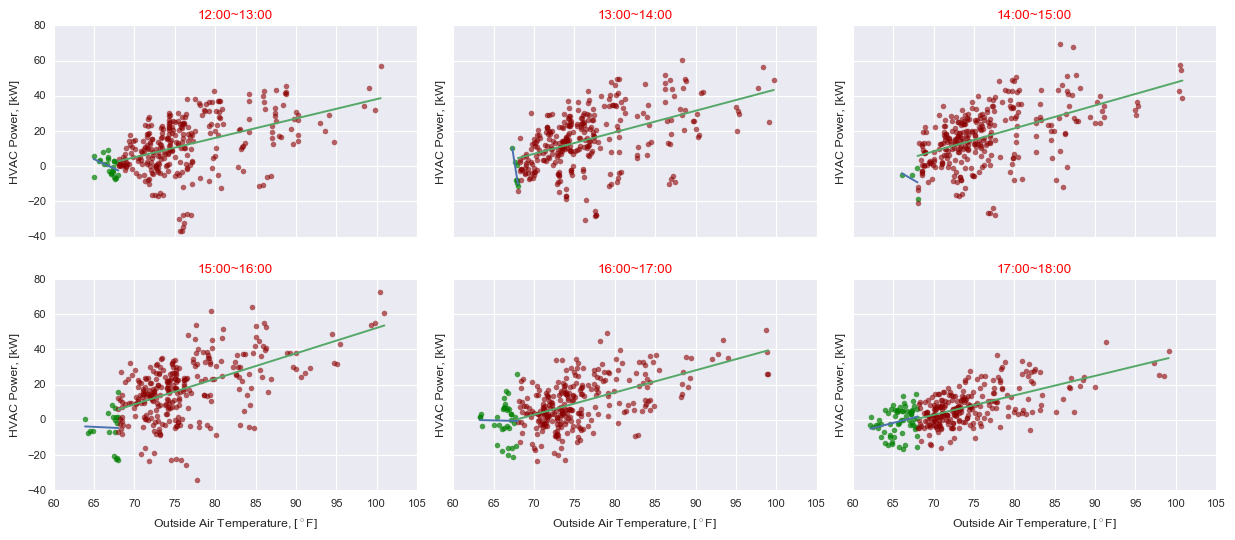

In [ ]:
hvac_scatter_1(df,'Bldg6311_HVAC')
hvac_scatter_2(df,'Bldg6311_HVAC')

In [ ]:
CG6315

,power,date,day,time,month,hour,weekday,year,holiday
2016-08-21 00:00:00,0.0,2016-08-21 00:00:00,08/21/16,00:00,8,0,6,2016,0
2016-08-21 00:15:00,0.0,2016-08-21 00:15:00,08/21/16,00:15,8,0,6,2016,0
2016-08-21 00:30:00,0.0,2016-08-21 00:30:00,08/21/16,00:30,8,0,6,2016,0
2016-08-21 00:45:00,0.0,2016-08-21 00:45:00,08/21/16,00:45,8,0,6,2016,0
2016-08-21 01:00:00,0.0,2016-08-21 01:00:00,08/21/16,01:00,8,1,6,2016,0
2016-08-21 01:15:00,0.0,2016-08-21 01:15:00,08/21/16,01:15,8,1,6,2016,0
2016-08-21 01:30:00,0.0,2016-08-21 01:30:00,08/21/16,01:30,8,1,6,2016,0
2016-08-21 01:45:00,0.0,2016-08-21 01:45:00,08/21/16,01:45,8,1,6,2016,0
2016-08-21 02:00:00,0.0,2016-08-21 02:00:00,08/21/16,02:00,8,2,6,2016,0
2016-08-21 02:15:00,0.0,2016-08-21 02:15:00,08/21/16,02:15,8,2,6,2016,0


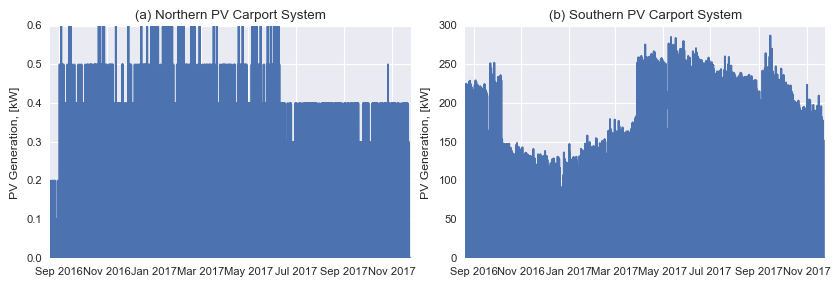

In [ ]:
fig, (axes) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .1, wspace=.15)
# fig.suptitle("Northern and Southern PV Carport System", fontsize=12)
axes[0].plot(CG6315.power)
axes[1].plot(RP6320.power)
axes[0].set_title("(a) Northern PV Carport System")
axes[0].set_ylabel('PV Generation, [kW]')
axes[1].set_title("(b) Southern PV Carport System")
axes[1].set_ylabel('PV Generation, [kW]')
fig.savefig('../results/PV.png', dpi=300, format='png',bbox_inches='tight')

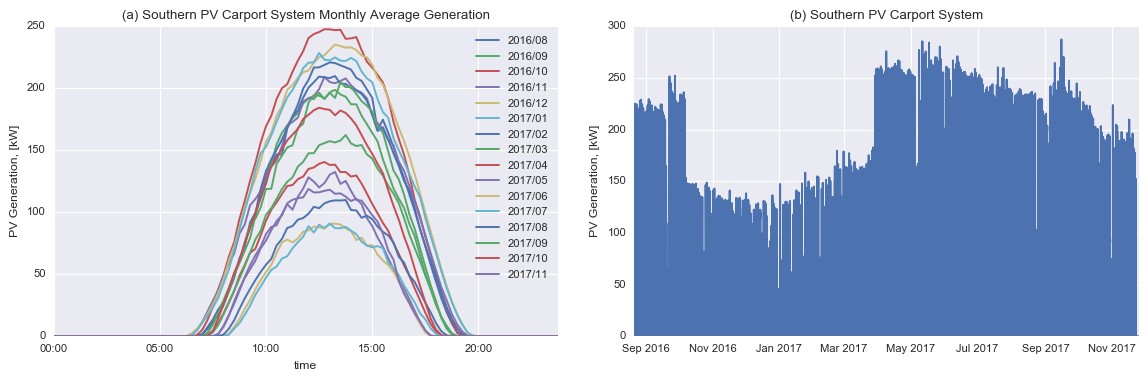

In [ ]:
RP6320['Month/Year'] = list(map(lambda x: x.strftime('%Y/%m'),RP6320.index))
RP6320Monthly = pd.DataFrame(RP6320.groupby(['Month/Year', 'time'])['power'].mean())

fig, (axes) = plt.subplots(1,2, figsize=(14, 4), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .1, wspace=.15)
# fig.suptitle("Northern and Southern PV Carport System", fontsize=12)
for item in RP6320Monthly.index.levels[0]:
    RP6320Monthly.loc[item,:].plot(ax=axes[0],label=item,legend=True)
axes[1].plot(RP6320.power)
axes[0].set_title("(a) Southern PV Carport System Monthly Average Generation")
axes[0].set_ylabel('PV Generation, [kW]')
axes[0].legend(RP6320Monthly.index.levels[0])
axes[1].set_title("(b) Southern PV Carport System")
axes[1].set_ylabel('PV Generation, [kW]')
fig.savefig('../results/PV_Monthly.png', dpi=300, format='png',bbox_inches='tight')

In [ ]:
WeatherSolar = pd.read_csv('../BldgPVData/Miramar_2016hourlyWeatherSolar.csv')
WeatherSolar['date'] = pd.to_datetime(WeatherSolar['Unnamed: 0'])
WeatherSolar.index = WeatherSolar.date
WeatherSolar15Min = WeatherSolar[['Ih']].resample('15min').interpolate(method='spline', order=2)
WeatherSolar15Min['date'] = WeatherSolar15Min.index

In [ ]:
RP6320.head()

,power,date,day,time,month,hour,weekday,year,holiday
2016-08-21 00:00:00,0.0,2016-08-21 00:00:00,08/21/16,00:00,8,0,6,2016,0
2016-08-21 00:15:00,0.0,2016-08-21 00:15:00,08/21/16,00:15,8,0,6,2016,0
2016-08-21 00:30:00,0.0,2016-08-21 00:30:00,08/21/16,00:30,8,0,6,2016,0
2016-08-21 00:45:00,0.0,2016-08-21 00:45:00,08/21/16,00:45,8,0,6,2016,0
2016-08-21 01:00:00,0.0,2016-08-21 01:00:00,08/21/16,01:00,8,1,6,2016,0


In [ ]:
RP6320Hourly = RP6320[['power','month','hour']].resample('H').mean()

In [ ]:
RP6320Hourly['date'] = RP6320Hourly.index
RP6320Hourly.head()

,power,month,hour,date
2016-08-21 00:00:00,0.0,8,0,2016-08-21 00:00:00
2016-08-21 01:00:00,0.0,8,1,2016-08-21 01:00:00
2016-08-21 02:00:00,0.0,8,2,2016-08-21 02:00:00
2016-08-21 03:00:00,0.0,8,3,2016-08-21 03:00:00
2016-08-21 04:00:00,0.0,8,4,2016-08-21 04:00:00


In [ ]:
RP6320HourlyDataset = pd.merge(RP6320Hourly, WeatherSolar, how='inner', on=['date'])

/Users/ryin/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
RP6320HourlyDataset.to_csv('../results/CarportPVDatasetHourly.csv')

In [ ]:
SolarAngles = pd.read_csv('../BldgPVData/Miramar_2016hourlySolarAngles.csv')
SolarAngles['date'] = pd.to_datetime(SolarAngles['Unnamed: 0'])
SolarAngles.index = SolarAngles.date
SolarAngles15Min = SolarAngles[['declination']].resample('15min').interpolate(method='linear')
SolarAngles15Min['date'] = SolarAngles15Min.index

In [ ]:
RP6320_oat = pd.merge(RP6320, weather[['date','oat']], how='inner', on=['date'])
RP6320_oat_solar = pd.merge(RP6320_oat, WeatherSolar15Min[['date','Ih']], how='inner', on=['date'])
RP6320_oat_solar = pd.merge(RP6320_oat_solar, SolarAngles15Min[['date','declination']], how='inner', on=['date'])
RP6320_oat_solar.index = RP6320_oat_solar.date

In [ ]:
bldgWithPV_oat = pd.merge(bldgWithPV, weather[['date','cloudCover','dewPoint','humidity','oat','windSpeed']], how='inner', on=['date'])
bldgWithPV_oat_solar = pd.merge(bldgWithPV_oat, WeatherSolar15Min[['date','Ih']], how='inner', on=['date'])
bldgWithPV_oat_solar.index = bldgWithPV_oat_solar.date

/Users/ryin/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
bldgWithPV_oat_solar.head()

,Bldg,date,day,time,month,hour,weekday,year,holiday,RooftopSolar,BldgPowerOnly,Month/Year,cloudCover,dewPoint,humidity,oat,windSpeed,Ih
date,,,,,,,,,,,,,,,,,,
2016-08-21 00:00:00,16.4,2016-08-21 00:00:00,08/21/16,00:00,8,0,6,2016,0,0.0,16.4,2016/08,0.1600,16.8100,0.8300,67.568,1.890,0.000000
2016-08-21 00:15:00,16.4,2016-08-21 00:15:00,08/21/16,00:15,8,0,6,2016,0,0.0,16.4,2016/08,0.1475,16.8125,0.8325,67.460,1.955,0.001196
2016-08-21 00:30:00,15.6,2016-08-21 00:30:00,08/21/16,00:30,8,0,6,2016,0,0.0,15.6,2016/08,0.1350,16.8150,0.8350,67.352,2.020,0.005421
2016-08-21 00:45:00,16.5,2016-08-21 00:45:00,08/21/16,00:45,8,0,6,2016,0,0.0,16.5,2016/08,0.1225,16.8175,0.8375,67.244,2.085,0.008153
2016-08-21 01:00:00,15.4,2016-08-21 01:00:00,08/21/16,01:00,8,1,6,2016,0,0.0,15.4,2016/08,0.1100,16.8200,0.8400,67.136,2.150,0.000000


In [ ]:
test = RP6320_oat_solar[(RP6320_oat_solar['hour']==19)][['power','Ih','oat']]

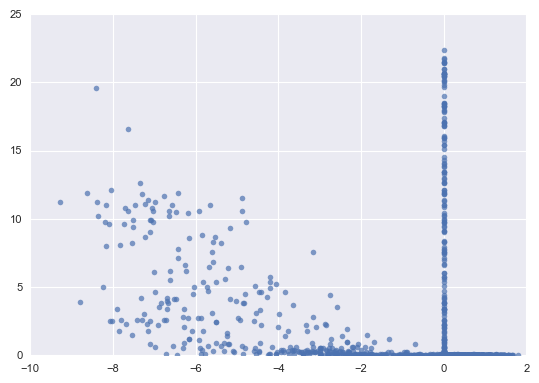

In [ ]:
plt.plot(test.Ih,test.power,'o',alpha=0.7,ms=4)

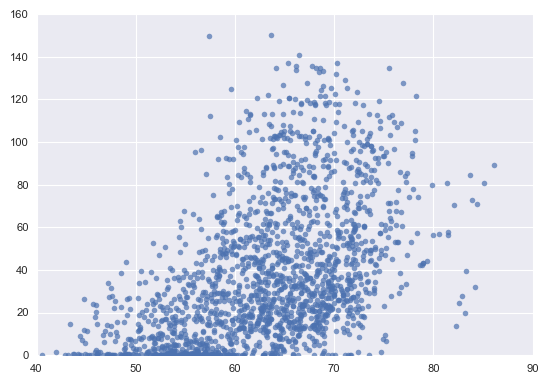

In [ ]:
plt.plot(test.oat,test.power,'o',alpha=0.7,ms=4)

In [ ]:
test = RP6320_oat_solar[(RP6320_oat_solar['month']==8)&(RP6320_oat_solar['hour']<=12)][['power','Ih','oat']]

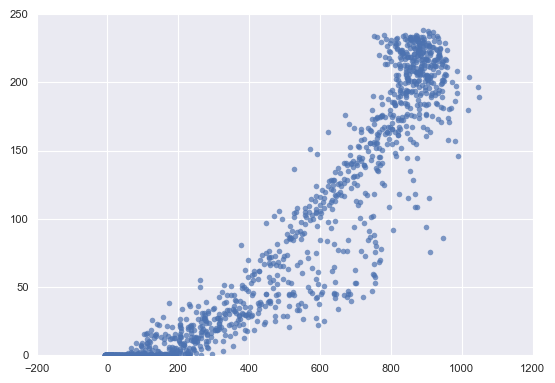

In [ ]:
plt.plot(test.Ih,test.power,'o',alpha=0.7,ms=4)

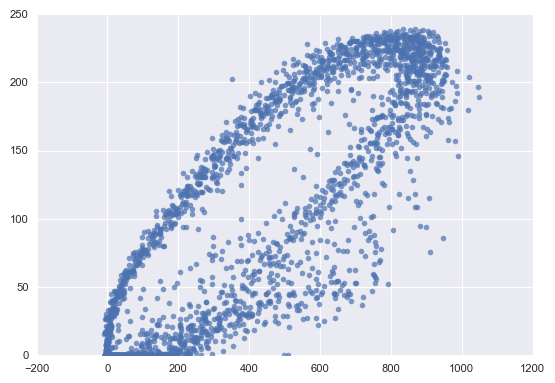

In [ ]:
test = RP6320_oat_solar[(RP6320_oat_solar['month']==8)][['power','Ih','oat']]
plt.plot(test.Ih,test.power,'o',alpha=0.7,ms=4)

In [ ]:
RP6320_oat_solar['adjustmentFactor'] = 

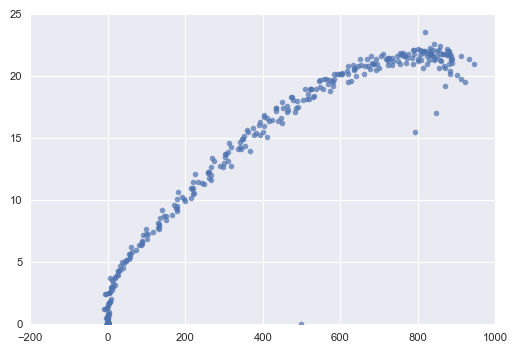

In [ ]:
testdf=bldgWithPV_oat_solar[:'2017-01-19 ']
test = testdf[(testdf['month']==8)&(testdf['hour']>=12)][['RooftopSolar','Ih','oat']]
plt.plot(test.Ih,test.RooftopSolar,'o',alpha=0.7,ms=4)

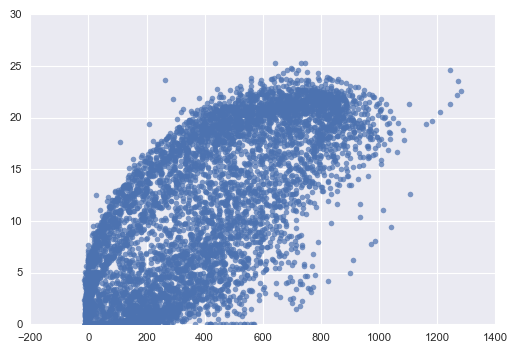

In [ ]:
testdf=bldgWithPV_oat_solar[:'2017-01-19 ']
test = testdf[(testdf['month']<=12)&(testdf['hour']<=24)][['RooftopSolar','Ih','oat']]
plt.plot(test.Ih,test.RooftopSolar,'o',alpha=0.7,ms=4)

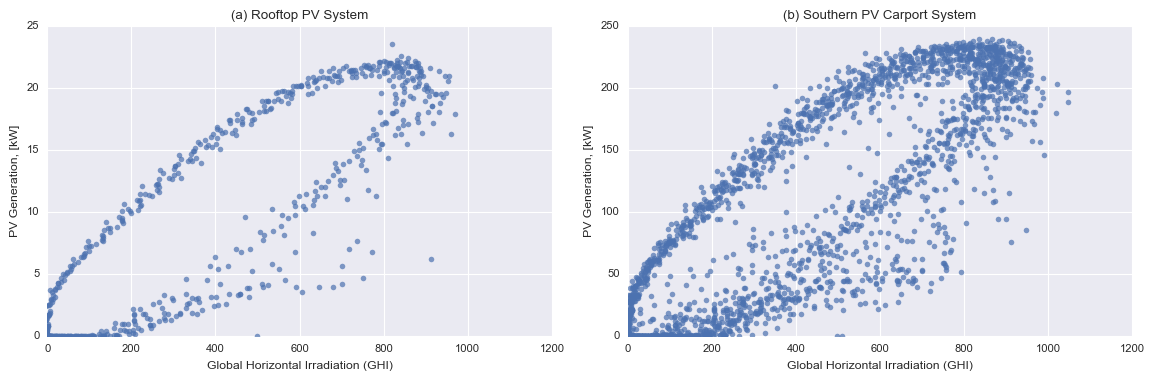

In [ ]:
fig, (axes) = plt.subplots(1,2, figsize=(14, 4), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .1, wspace=.15)

test = testdf[(testdf['month']==8)][['RooftopSolar','Ih','oat']]
axes[0].plot(test.Ih,test.RooftopSolar,'o',alpha=0.7,ms=4)
axes[0].set_title("(a) Rooftop PV System")
axes[0].set_ylabel('PV Generation, [kW]')
axes[0].set_xlim(0,1200)
axes[0].set_xlabel('Global Horizontal Irradiation (GHI)')

test = RP6320_oat_solar[(RP6320_oat_solar['month']==8)][['power','Ih','oat']]
axes[1].plot(test.Ih,test.power,'o',alpha=0.7,ms=4)
axes[1].set_title("(b) Southern PV Carport System")
axes[1].set_ylabel('PV Generation, [kW]')
axes[1].set_xlim(0,1200)
axes[1].set_xlabel('Global Horizontal Irradiation (GHI)')
fig.savefig('../results/PV_Prediction.png', dpi=300, format='png',bbox_inches='tight')

In [ ]:
bldgWithPV_oat_solar.to_csv('RooftopPVDataset.csv')

In [ ]:
RP6320_oat_solar.to_csv('CarportPVDataset.csv')

In [ ]:
WeatherSolar['2017-01-10']['In']

date
2017-01-10 00:00:00      0.621856
2017-01-10 01:00:00      0.621856
2017-01-10 02:00:00      0.621856
2017-01-10 03:00:00      0.621856
2017-01-10 04:00:00      0.621856
2017-01-10 05:00:00      0.621856
2017-01-10 06:00:00      0.621856
2017-01-10 07:00:00      0.574435
2017-01-10 08:00:00     51.446864
2017-01-10 09:00:00     70.920948
2017-01-10 10:00:00     87.197535
2017-01-10 11:00:00    383.446316
2017-01-10 12:00:00    542.509082
2017-01-10 13:00:00    614.555088
2017-01-10 14:00:00    543.108897
2017-01-10 15:00:00    266.175307
2017-01-10 16:00:00    163.587771
2017-01-10 17:00:00      0.621856
2017-01-10 18:00:00      0.621856
2017-01-10 19:00:00      0.621856
2017-01-10 20:00:00      0.621856
2017-01-10 21:00:00      0.621856
2017-01-10 22:00:00      0.621856
2017-01-10 23:00:00      0.621856
Name: In, dtype: float64

In [ ]:
WeatherSolar.columns

Index(['Unnamed: 0', 'time', 'apparentTemperature', 'cloudCover', 'dewPoint',
       'humidity', 'icon', 'ozone', 'precipIntensity', 'precipProbability',
       'precipType', 'pressure', 'summary', 'temperature', 'uvIndex',
       'visibility', 'windBearing', 'windGust', 'windSpeed', 'temperature_3',
       'date', 'Ih', 'In', 'Id', 'Kt', 'Kn'],
      dtype='object')

In [ ]:
pi = np.pi
RP6320_oat_solar['Alpha'] = RP6320_oat_solar['declination'].apply(lambda x: math.sin((90+x-32.7157) * pi / 180))
RP6320_oat_solar['AlphaBeta'] = RP6320_oat_solar['declination'].apply(lambda x: math.sin((90+x-32.7157+20) * pi / 180))
RP6320_oat_solar['factor'] = RP6320_oat_solar['AlphaBeta']/RP6320_oat_solar['Alpha']

In [ ]:
df_training = df['2016-08-21':'2016-09-21'].copy()
    
df_wd = df_training.loc[(df_training['weekday'] >= 0) & (df_training['weekday'] <= 4) & (df_training['holiday'] == 0)]
df_wk = df_training.loc[(df_training.weekday.apply(lambda x: x in [5,6])) | (df_training['holiday'] == 1)]

with open('../results/linearmodel_wd.csv','w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['hour','slope1', 'intercept1', 'r_value1', 'p_value1', 'std_err1','slope2', 'intercept2', 'r_value2', 'p_value2', 'std_err2'])
    for i in range(24):
        x1 = df_wd.loc[(df_wd['hour'] == i) & (df_wd['oat'] <= 68),['oat','BldgPowerOnly']].oat
        y1 = df_wd.loc[(df_wd['hour'] == i) & (df_wd['oat'] <= 68),['oat','BldgPowerOnly']].BldgPowerOnly
        x2 = df_wd.loc[(df_wd['hour'] == i) & (df_wd['oat'] > 68),['oat','BldgPowerOnly']].oat
        y2 = df_wd.loc[(df_wd['hour'] == i) & (df_wd['oat'] > 68),['oat','BldgPowerOnly']].BldgPowerOnly

        TempBreaks = [68,95]
        try:
            slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)
            z1_err = [r_value1**2, std_err1]
            r_err1 = abs(((x1 * slope1 + intercept1)-y1) / y1)
        except (TypeError, ValueError):
            print("Empty OAT >= 68F")
        try:
            slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2,y2)
            z2_err = [r_value2**2, std_err2]
            r_err2 = abs(((x2 * slope2 + intercept2)-y2) / y2)
        except (TypeError, ValueError):
            print("Empty OAT >= 68F")
        writer.writerow([i,slope1, intercept1, r_value1, p_value1, std_err1,slope2, intercept2, r_value2, p_value2, std_err2])
with open('../results/linearmodel_wk.csv','w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['hour','slope1', 'intercept1', 'r_value1', 'p_value1', 'std_err1','slope2', 'intercept2', 'r_value2', 'p_value2', 'std_err2'])
    for i in range(24):
        x1 = df_wk.loc[(df_wk['hour'] == i),['oat','BldgPowerOnly']].oat
        y1 = df_wk.loc[(df_wk['hour'] == i),['oat','BldgPowerOnly']].BldgPowerOnly

        TempBreaks = [68,95]
        try:
            slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1,y1)
            z1_err = [r_value1**2, std_err1]
            r_err1 = abs(((x1 * slope1 + intercept1)-y1) / y1)
        except (TypeError, ValueError):
            print("Empty OAT >= 68F")
        try:
            slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2,y2)
            z2_err = [r_value2**2, std_err2]
            r_err2 = abs(((x2 * slope2 + intercept2)-y2) / y2)
        except (TypeError, ValueError):
            print("Empty OAT >= 68F")
        writer.writerow([i,slope1, intercept1, r_value1, p_value1, std_err1,slope2, intercept2, r_value2, p_value2, std_err2])

/Users/ryin/anaconda/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:93: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/ryin/anaconda/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:95: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/ryin/anaconda/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:97: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Empty OAT >= 68F
Empty OAT >= 68F
Empty OAT >= 68F
Empty OAT >= 68F
Empty OAT >= 68F


In [ ]:
x1 = df_wd.loc[(df_wd['hour'] == 13) & (df_wd['oat'] > 68),['oat','BldgPowerOnly']].oat
y1 = df_wd.loc[(df_wd['hour'] == 13) & (df_wd['oat'] > 68),['oat','BldgPowerOnly']].BldgPowerOnly

In [ ]:
lr_wd_coef = pd.read_csv('../results/linearmodel_wd.csv')
lr_wk_coef = pd.read_csv('../results/linearmodel_wk.csv')

In [ ]:
lr_wd_coef[lr_wd_coef['hour']==0][['slope1','intercept1']]

['slope1', 'intercept1']

In [ ]:
def get_model_coef(hour,oat,lr_wd_coef):
    if oat<=68:
        output = lr_wd_coef[lr_wd_coef['hour']==hour]['intercept1']+oat*lr_wd_coef[lr_wd_coef['hour']==hour]['slope1']
#         print(output.values)
        return output.values[0]
    else:
        output = lr_wd_coef[lr_wd_coef['hour']==hour]['intercept2']+oat*lr_wd_coef[lr_wd_coef['hour']==hour]['slope2']
        return output.values[0]

In [ ]:
predict = df['2016-09-15':'2016-09-16'].copy()

In [ ]:
predict['predict_bldgpower']=list(map(lambda hour,oat: get_model_coef(hour,oat,lr_wd_coef), predict['hour'],predict['oat']))

In [ ]:
predict

,Bldg,date,day,time,month,hour,weekday,year,holiday,RooftopSolar,BldgPowerOnly,Month/Year,oat,predict_bldgpower
date,,,,,,,,,,,,,,
2016-09-15 00:00:00,14.9,2016-09-15 00:00:00,09/15/16,00:00,9,0,3,2016,0,0.0,14.9,2016/09,62.0780,15.400982
2016-09-15 00:15:00,15.0,2016-09-15 00:15:00,09/15/16,00:15,9,0,3,2016,0,0.0,15.0,2016/09,61.6190,15.347228
2016-09-15 00:30:00,14.7,2016-09-15 00:30:00,09/15/16,00:30,9,0,3,2016,0,0.0,14.7,2016/09,61.1600,15.293474
2016-09-15 00:45:00,14.5,2016-09-15 00:45:00,09/15/16,00:45,9,0,3,2016,0,0.0,14.5,2016/09,60.7010,15.239721
2016-09-15 01:00:00,15.3,2016-09-15 01:00:00,09/15/16,01:00,9,1,3,2016,0,0.0,15.3,2016/09,60.2420,15.000103
2016-09-15 01:15:00,14.7,2016-09-15 01:15:00,09/15/16,01:15,9,1,3,2016,0,0.0,14.7,2016/09,59.9855,14.966819
2016-09-15 01:30:00,14.9,2016-09-15 01:30:00,09/15/16,01:30,9,1,3,2016,0,0.0,14.9,2016/09,59.7290,14.933535
2016-09-15 01:45:00,14.6,2016-09-15 01:45:00,09/15/16,01:45,9,1,3,2016,0,0.0,14.6,2016/09,59.4725,14.900251
2016-09-15 02:00:00,15.5,2016-09-15 02:00:00,09/15/16,02:00,9,2,3,2016,0,0.0,15.5,2016/09,59.2160,16.327302


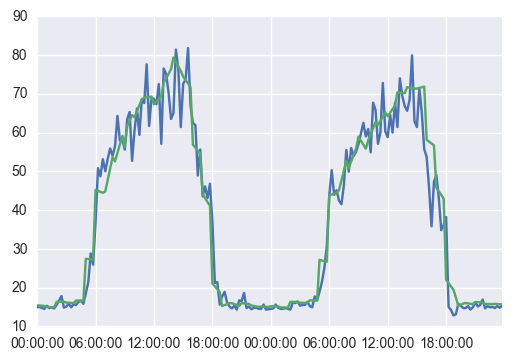

In [ ]:
plt.plot(predict.BldgPowerOnly)
plt.plot(predict.predict_bldgpower)

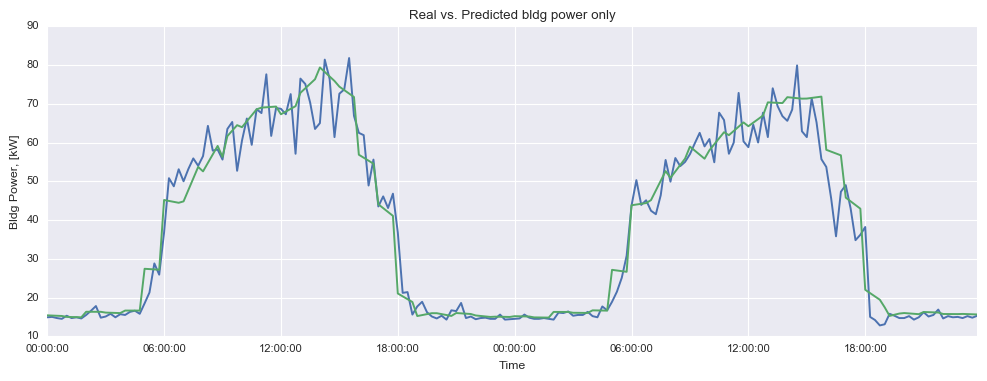

In [ ]:
sns.set_context('paper')
fig, (axes) = plt.subplots(1,1, figsize=(12, 4), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .1, wspace=.15)

axes.plot(predict.BldgPowerOnly)
axes.plot(predict.predict_bldgpower)
axes.set_title("Real vs. Predicted bldg power only")
axes.set_ylabel('Bldg Power, [kW]')
# axes.set_xlim(0,1200)
axes.set_xlabel('Time')
fig.savefig('../results/Bldg_Prediction.png', dpi=300, format='png',bbox_inches='tight')

In [ ]:
np.std(predict.BldgPowerOnly-predict.predict_bldgpower)/predict.BldgPowerOnly.mean()

0.12983109303694604

In [ ]:
abs((predict.BldgPowerOnly-predict.predict_bldgpower)/predict.BldgPowerOnly).mean()

0.08790389726946095

In [ ]:
solar_factors = ['month', 'hour', 'RooftopSolar','cloudCover','dewPoint','humidity','oat','windSpeed', 'Ih']

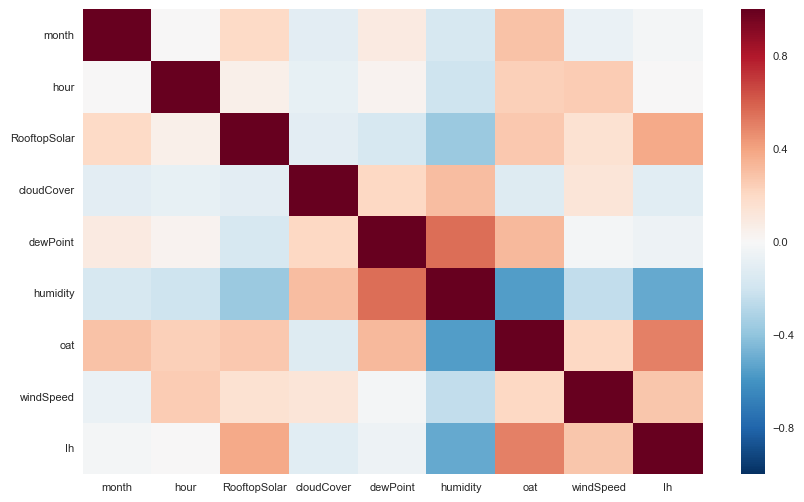

In [ ]:
sns.set_context('paper')
fig, (axes) = plt.subplots(1,1, figsize=(10, 6), facecolor='w', edgecolor='k', sharey=False, sharex=False)
fig.subplots_adjust(hspace = .1, wspace=.15)

sns.heatmap(bldgWithPV_oat_solar[solar_factors].corr(), ax=axes)
# axes.set_title("Real vs. Predicted bldg power only")
# axes.set_ylabel('Bldg Power, [kW]')
# axes.set_xlim(0,1200)
# axes.set_xlabel('Time')
fig.savefig('../results/solar_corr.png', dpi=300, format='png',bbox_inches='tight')


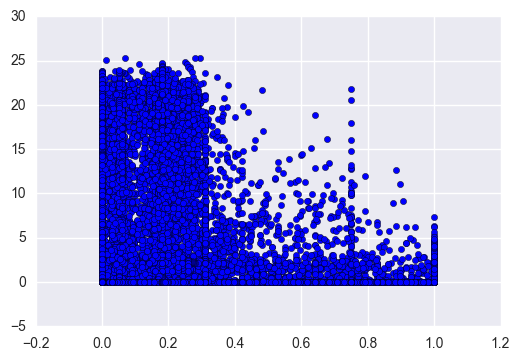

In [ ]:
plt.scatter(bldgWithPV_oat_solar.cloudCover, bldgWithPV_oat_solar.RooftopSolar)
plt.show()

/Users/ryin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  if __name__ == '__main__':
/Users/ryin/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=8.0, right=8.0
  'left=%s, right=%s') % (left, right))
/Users/ryin/anaconda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=8.0, top=8.0
  'bottom=%s, top=%s') % (bottom, top))
/Users/ryin/anaconda/lib/python3.5/site-packages/pandas/plotting/_misc.py:123: RuntimeWarning: invalid value encountered in true_divide
  adj = (locs - lim1[0]) / (lim1[1] - lim1[0])


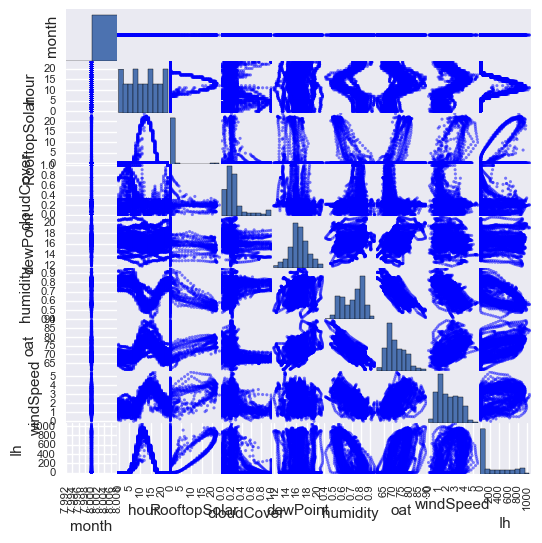

In [ ]:
pd.scatter_matrix(bldgWithPV_oat_solar.loc[bldgWithPV_oat_solar['month']==8,solar_factors], figsize=(6, 6))
plt.show()

In [ ]:
bldgWithPV_oat_solar.head()

,Bldg,date,day,time,month,hour,weekday,year,holiday,RooftopSolar,BldgPowerOnly,Month/Year,cloudCover,dewPoint,humidity,oat,windSpeed,Ih
date,,,,,,,,,,,,,,,,,,
2016-08-21 00:00:00,16.4,2016-08-21 00:00:00,08/21/16,00:00,8,0,6,2016,0,0.0,16.4,2016/08,0.1600,16.8100,0.8300,67.568,1.890,0.000000
2016-08-21 00:15:00,16.4,2016-08-21 00:15:00,08/21/16,00:15,8,0,6,2016,0,0.0,16.4,2016/08,0.1475,16.8125,0.8325,67.460,1.955,0.001196
2016-08-21 00:30:00,15.6,2016-08-21 00:30:00,08/21/16,00:30,8,0,6,2016,0,0.0,15.6,2016/08,0.1350,16.8150,0.8350,67.352,2.020,0.005421
2016-08-21 00:45:00,16.5,2016-08-21 00:45:00,08/21/16,00:45,8,0,6,2016,0,0.0,16.5,2016/08,0.1225,16.8175,0.8375,67.244,2.085,0.008153
2016-08-21 01:00:00,15.4,2016-08-21 01:00:00,08/21/16,01:00,8,1,6,2016,0,0.0,15.4,2016/08,0.1100,16.8200,0.8400,67.136,2.150,0.000000
